In [1]:
import os
import sys
import path
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
sys.path.insert(0, path.Path(os.getcwd()).joinpath("..").abspath())

## Common

In [2]:
import os

import numpy as np
import pandas as pd
import torch

from catalyst import utils
from catalyst.data import transforms
from catalyst.contrib.datasets import CIFAR10

from captum.attr import visualization as viz
from captum.attr import (
    Saliency, 
    IntegratedGradients,
    NoiseTunnel,
    LayerGradCam, 
    FeatureAblation, 
    LayerActivation, 
    LayerAttribution
)

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [3]:
def unnormalize(tensor: torch.Tensor, mean, std, inplace=False):
    """Normalize a tensor image with mean and standard deviation.

    .. note::
        This transform acts out of place by default, i.e., it does not mutates the input tensor.

    Args:
        tensor: Tensor image of size (C, H, W) to be normalized.
        mean: Sequence of means for each channel.
        std: Sequence of standard deviations for each channel.
        inplace(bool,optional): Bool to make this operation inplace.

    Returns:
        torch.Tensor: Normalized Tensor image.

    Raises:
        TypeError: if `tensor` is not torch.Tensor
    """
    if not (torch.is_tensor(tensor) and tensor.ndimension() == 3):
        raise TypeError("tensor is not a torch image.")

    if not inplace:
        tensor = tensor.clone()

    dtype = tensor.dtype
    mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=dtype, device=tensor.device)
    tensor.mul_(std[:, None, None]).add_(mean[:, None, None])
    return tensor

In [4]:
class EncoderWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        x, _ = self.module(x)
        return x

class HeadWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        x = self.module.classifier(x).mean(1)
        return x

class ModelWrapper(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        _, x = self.module(x)
        return x

In [5]:
def attribute_image_features(algorithm, model, features, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(
        features,
        target=label, 
        **kwargs
    )
    
    return tensor_attributions

### Image

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
valid_dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

In [ ]:
features, label = valid_dataset[10]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [ ]:
plt.imshow(
    unnormalize(
        features[0].detach(), 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    ).permute(1, 2, 0)
)

In [ ]:
from image.train import resnet9

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = resnet9(in_channels=3, num_classes=10)
utils.unpack_checkpoint(checkpoint, model=model)
model = ModelWrapper(model)

In [ ]:
saliency = Saliency(model)
grads = saliency.attribute(features, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features, 
    label,
    baselines=features * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features, 
    label,
    baselines=features * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=100, 
    stdevs=0.2
)

In [ ]:
plt.imshow(
    unnormalize(
        features[0].detach(), 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    ).permute(1, 2, 0)
)

In [ ]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(grads.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

In [ ]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

In [ ]:
# plt.matshow(attr_ig_nt.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1
)

#### Comparison

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

axs[0].imshow(
    unnormalize(
        features[0].detach(), 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5)
    ).permute(1, 2, 0)
)

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    _ = viz.visualize_image_attr(
        np.transpose(show_attr.squeeze().cpu().detach().numpy(), (1,2,0)),
        np.transpose(features.squeeze().cpu().detach().numpy(), (1,2,0)),
        method='heat_map',
        cmap=default_cmap,
        show_colorbar=True,
        sign='positive',
        outlier_perc=1,
        plt_fig_axis=(fig, axs[i+1]),
        use_pyplot=False,
    )

plt.show()

### Video

In [6]:
from introspection.datasets import TemporalDataset
from introspection.settings import DATA_ROOT

valid_csv = pd.read_csv(
    f"{DATA_ROOT}/UCF11_updated_mpg_clean/valid.csv",
    header=None,
    names=["path", "class", "length"],
)

num_segments = 1
assert num_segments == 1
segment_len = 5
valid_dataset = TemporalDataset(
    valid_csv,
    f"{DATA_ROOT}/UCF11_updated_mpg",
    num_segments=num_segments,
    segment_len=segment_len,
)

In [7]:
features, label = valid_dataset[0]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [8]:
features.shape

torch.Size([1, 5, 3, 224, 224])

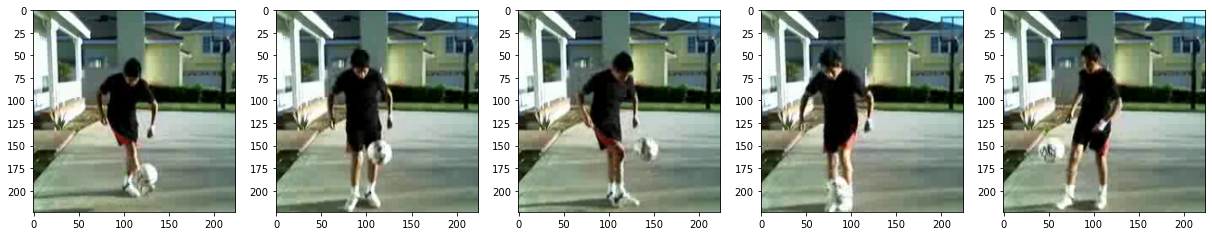

In [9]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

In [17]:
from introspection.modules import TemporalResNet

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = TemporalResNet(emb_features=256, out_features=11)
utils.unpack_checkpoint(checkpoint, model=model)
model = ModelWrapper(model)

In [18]:
saliency = Saliency(model)
grads = saliency.attribute(features, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

/home/scitator/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(
    ig, 
    model,
    features, 
    label,
    baselines=features * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([2.2957], dtype=torch.float64)


In [20]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    model,
    features, 
    label,
    baselines=features * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

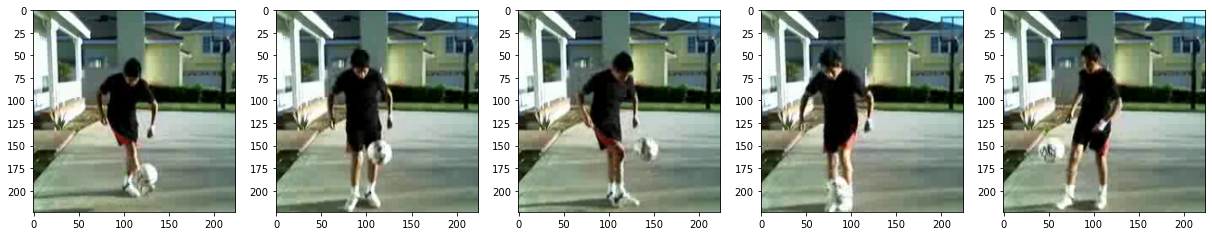

In [21]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))
for i in range(num_segments):
    for j in range(segment_len):
        axs[j].imshow(features[0, i*num_segments+j].detach().permute(1, 2, 0))

plt.show()

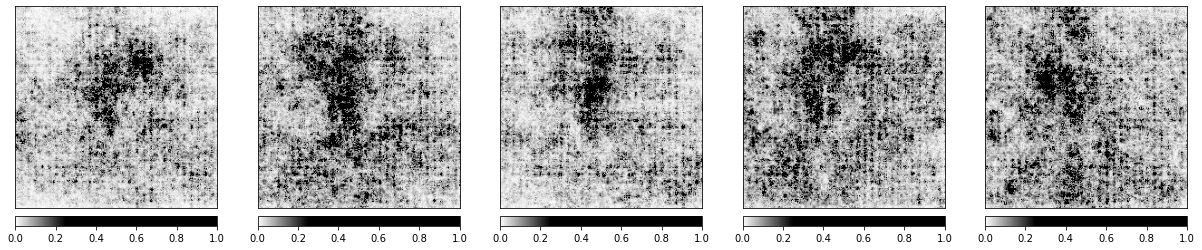

In [22]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
#         axs[i, j].imshow(grads[0, i*num_segments+j].detach().permute(1, 2, 0))
        _ = viz.visualize_image_attr(
            np.transpose(grads[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

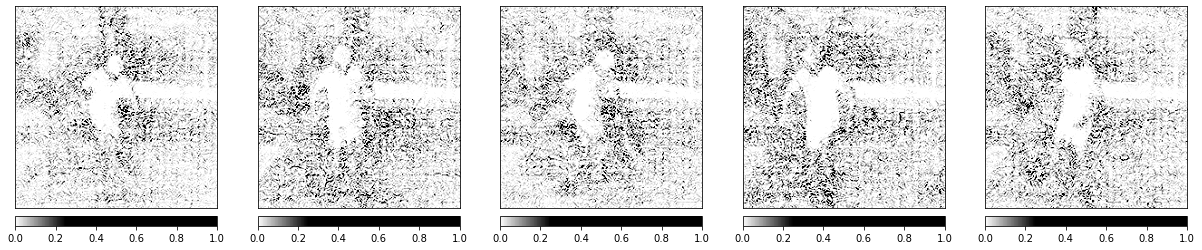

In [23]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
#         axs[i, j].imshow(attr_ig[0, i*num_segments+j].detach().permute(1, 2, 0))
        _ = viz.visualize_image_attr(
            np.transpose(attr_ig[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

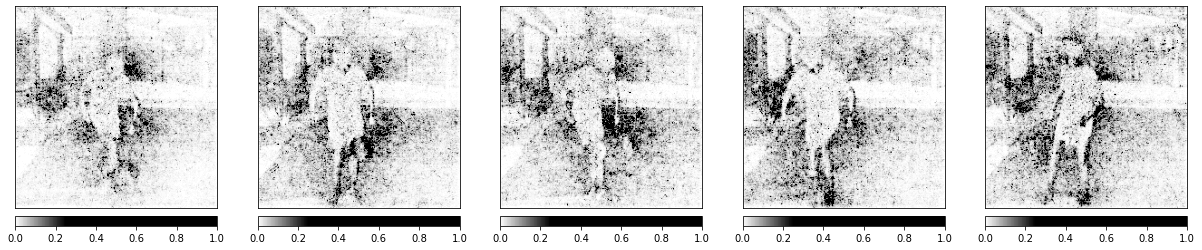

In [24]:
fig, axs = plt.subplots(num_segments, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for i in range(num_segments):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(attr_ig_nt[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, i*num_segments+j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[j]),
            use_pyplot=False,
        )

plt.show()

#### Comparison

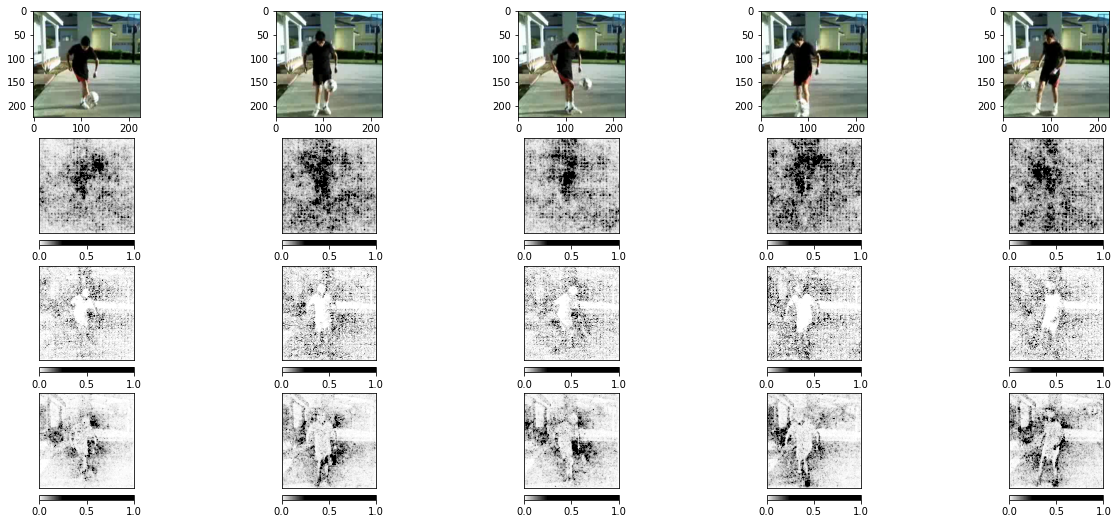

In [25]:
fig, axs = plt.subplots(4, segment_len, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

for j in range(segment_len):
    axs[0, j].imshow(features[0, j].detach().permute(1, 2, 0))

for i, show_attr in enumerate([grads, attr_ig, attr_ig_nt]):
    for j in range(segment_len):
        _ = viz.visualize_image_attr(
            np.transpose(show_attr[0, j].cpu().detach().numpy(), (1,2,0)),
            np.transpose(features[0, j].cpu().detach().numpy(), (1,2,0)),
            method='heat_map',
            cmap=default_cmap,
            show_colorbar=True,
            sign='positive',
            outlier_perc=1,
            plt_fig_axis=(fig, axs[i+1, j]),
            use_pyplot=False,
        )

plt.show()

### Video-features

In [6]:
from introspection.datasets import TemporalDataset
from introspection.settings import DATA_ROOT

valid_csv = pd.read_csv(
    f"{DATA_ROOT}/UCF11_updated_mpg_clean/valid.csv",
    header=None,
    names=["path", "class", "length"],
)

valid_dataset = TemporalDataset(
    valid_csv,
    f"{DATA_ROOT}/UCF11_updated_mpg",
    num_segments=None,
    segment_len=None,
)

In [7]:
features, label = valid_dataset[0]

features = torch.tensor(features).unsqueeze(0)
features.requires_grad = True

label = torch.tensor(label).unsqueeze(0)

In [8]:
features.shape

torch.Size([1, 240, 3, 224, 224])

In [9]:
from introspection.modules import TemporalResNet

logdir = "../logs/.../"
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
model = TemporalResNet(emb_features=256, out_features=11)
utils.unpack_checkpoint(checkpoint, model=model)
encoder = EncoderWrapper(model)
head = HeadWrapper(model)

In [10]:
features2 = encoder(features)

/home/scitator/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
features2.shape

torch.Size([1, 240, 256])

In [12]:
saliency = Saliency(head)
grads = saliency.attribute(features2, target=label.item())
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [13]:
ig = IntegratedGradients(head)
attr_ig, delta = attribute_image_features(
    ig, 
    head,
    features2, 
    label,
    baselines=features2 * 0, 
    return_convergence_delta=True
)
# attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([8.9807e-08], dtype=torch.float64)


In [14]:
ig = IntegratedGradients(head)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(
    nt, 
    head,
    features2, 
    label,
    baselines=features2 * 0, 
    nt_type='smoothgrad_sq',
    nt_samples=5, 
    stdevs=0.2
)

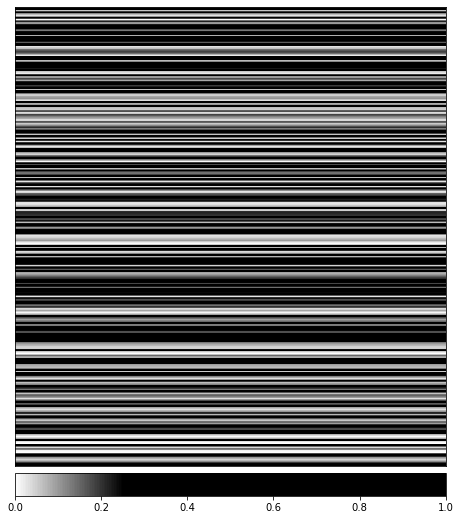

In [15]:
# plt.matshow(grads.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

# transpose to [num_features; time_len; 1]
_ = viz.visualize_image_attr(
    np.transpose(grads.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),  
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

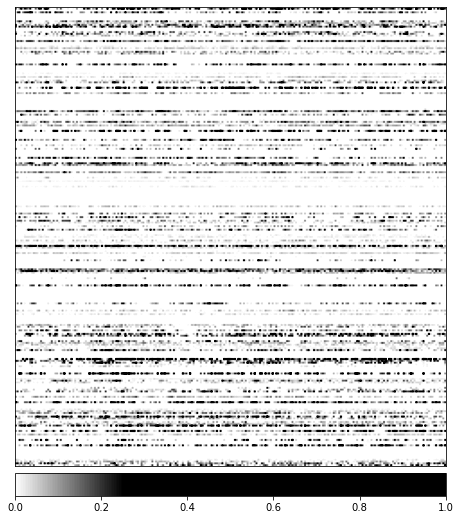

In [17]:
# plt.matshow(attr_ig.permute(0, 2, 3, 1).detach().cpu().numpy()[0])
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()

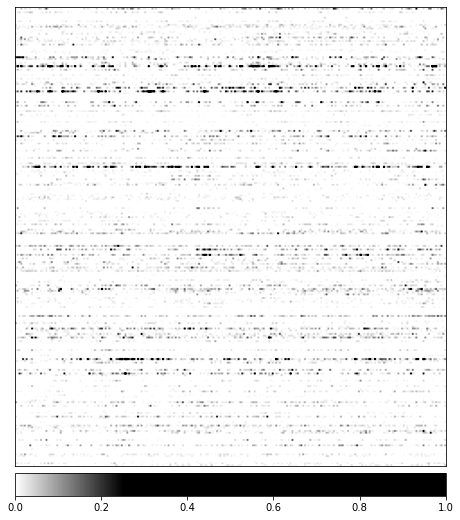

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(21, 9))

default_cmap = LinearSegmentedColormap.from_list(
    'custom blue', 
    [(0, '#ffffff'), (0.25, '#000000'), (1, '#000000')], 
    N=256
)

_ = viz.visualize_image_attr(
    np.transpose(attr_ig_nt.cpu().detach().numpy(), (2,1,0)),
    np.transpose(features2.cpu().detach().numpy(), (2,1,0)),
    method='heat_map',
    cmap=default_cmap,
    show_colorbar=True,
    sign='positive',
    outlier_perc=1,
    plt_fig_axis=(fig, axs),
    use_pyplot=False,
)

plt.show()